## IMPORTING LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Normalizer, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import joblib

## LOAD & EXPLORE DATA

DOWNLOAD DATASET FROM
https://www.kaggle.com/datasets/jijagallery/fitlife-health-and-fitness-tracking-dataset/data

In [5]:
df = pd.read_csv("../data/health_fitness_dataset.csv")
df.head()

,participant_id,date,age,gender,height_cm,weight_kg,activity_type,duration_minutes,intensity,calories_burned,...,stress_level,daily_steps,hydration_level,bmi,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,health_condition,smoking_status,fitness_level
0,1,2024-01-01,56,F,165.3,53.7,Dancing,41,Low,3.3,...,3,7128,1.5,19.6,69.5,110.7,72.9,None,Never,0.04
1,1,2024-01-04,56,F,165.3,53.9,Swimming,28,Low,2.9,...,7,7925,1.8,19.6,69.5,110.7,72.9,None,Never,0.07
2,1,2024-01-05,56,F,165.3,54.2,Swimming,21,Medium,2.6,...,7,7557,2.7,19.6,69.5,110.7,72.9,None,Never,0.09
3,1,2024-01-07,56,F,165.3,54.4,Weight Training,99,Medium,10.7,...,8,11120,2.6,19.6,69.5,110.7,72.9,None,Never,0.21
4,1,2024-01-09,56,F,165.3,54.7,Swimming,100,Medium,12.7,...,1,5406,1.5,19.6,69.5,110.7,72.9,None,Never,0.33


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687701 entries, 0 to 687700
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   participant_id            687701 non-null  int64  
 1   date                      687701 non-null  object 
 2   age                       687701 non-null  int64  
 3   gender                    687701 non-null  object 
 4   height_cm                 687701 non-null  float64
 5   weight_kg                 687701 non-null  float64
 6   activity_type             687701 non-null  object 
 7   duration_minutes          687701 non-null  int64  
 8   intensity                 687701 non-null  object 
 9   calories_burned           687701 non-null  float64
 10  avg_heart_rate            687701 non-null  int64  
 11  hours_sleep               687701 non-null  float64
 12  stress_level              687701 non-null  int64  
 13  daily_steps               687701 non-null  i

In [7]:
df["activity_type"].unique()

array(['Dancing', 'Swimming', 'Weight Training', 'HIIT', 'Running',
       'Walking', 'Tennis', 'Basketball', 'Yoga', 'Cycling'], dtype=object)

In [8]:
category_column = ["gender", "activity_type", "intensity", "stress_level", "health_condition", "smoking_status", "fitness_level"]
for category in category_column:
    print(category, df[category].unique())

gender ['F' 'M' 'Other']
activity_type ['Dancing' 'Swimming' 'Weight Training' 'HIIT' 'Running' 'Walking'
 'Tennis' 'Basketball' 'Yoga' 'Cycling']
intensity ['Low' 'Medium' 'High']
stress_level [ 3  7  8  1 10  5  2  6  9  4]
health_condition ['None' 'Diabetes' 'Hypertension' 'Asthma']
smoking_status ['Never' 'Current' 'Former']
fitness_level [ 0.04  0.07  0.09 ... 21.51 21.77 21.07]


In [9]:
for category in category_column:
    print(category,"\n", df[category].value_counts(),"\n")

gender 
 F        338856
M        334023
Other     14822
Name: gender, dtype: int64 

activity_type 
 Yoga               69961
Weight Training    69661
HIIT               69376
Dancing            69193
Cycling            69187
Basketball         68536
Tennis             68533
Walking            68077
Swimming           68032
Running            67145
Name: activity_type, dtype: int64 

intensity 
 Medium    343433
Low       206911
High      137357
Name: intensity, dtype: int64 

stress_level 
 8     73627
5     73426
4     73216
7     73145
6     73026
2     72947
3     72929
1     72736
10    51634
9     51015
Name: stress_level, dtype: int64 

health_condition 
 None            490275
Hypertension     99437
Diabetes         64754
Asthma           33235
Name: health_condition, dtype: int64 

smoking_status 
 Never      416800
Former     164570
Current    106331
Name: smoking_status, dtype: int64 

fitness_level 
 0.12     439
5.92     423
5.66     423
7.49     423
7.98     420
        

In [10]:
len(df["fitness_level"].unique())

2166

## CREATE DATA SUBSET

In [11]:
# Define categorical and numerical features
categorical_features = ['gender', 'activity_type', 'intensity']  # Add other categorical columns
numerical_features = ['age', 'weight_kg', 'height_cm', 'bmi', 'duration_minutes', ]

# Define sample size per group (adjust as needed)
n_samples_per_group = 1000  

# Stratified sampling across multiple categorical features
df_sample = df.groupby(categorical_features).apply(lambda x: x.sample(n=min(n_samples_per_group, len(x)), random_state=42)).reset_index(drop=True)

# Check balance in categorical features
print(df_sample[categorical_features].value_counts())

# Verify numerical feature distribution
print(df_sample[numerical_features].describe())


gender  activity_type  intensity
F       Basketball     High         1000
M       Basketball     Low          1000
        Cycling        High         1000
                       Low          1000
                       Medium       1000
                                    ... 
Other   Cycling        High          288
        Running        High          287
        Walking        High          277
        HIIT           High          267
        Swimming       High          249
Length: 90, dtype: int64
                age     weight_kg     height_cm           bmi  \
count  74822.000000  74822.000000  74822.000000  74822.000000   
mean      41.934832     94.904868    168.594543     22.741672   
std       13.531782     22.262130      8.767727      3.512797   
min       18.000000     45.300000    145.000000     14.200000   
25%       30.000000     78.200000    162.100000     20.200000   
50%       43.000000     94.600000    168.300000     22.400000   
75%       54.000000    110.400000   

In [12]:
df_sample["gender"].value_counts()

F        30000
M        30000
Other    14822
Name: gender, dtype: int64

In [13]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74822 entries, 0 to 74821
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   participant_id            74822 non-null  int64  
 1   date                      74822 non-null  object 
 2   age                       74822 non-null  int64  
 3   gender                    74822 non-null  object 
 4   height_cm                 74822 non-null  float64
 5   weight_kg                 74822 non-null  float64
 6   activity_type             74822 non-null  object 
 7   duration_minutes          74822 non-null  int64  
 8   intensity                 74822 non-null  object 
 9   calories_burned           74822 non-null  float64
 10  avg_heart_rate            74822 non-null  int64  
 11  hours_sleep               74822 non-null  float64
 12  stress_level              74822 non-null  int64  
 13  daily_steps               74822 non-null  int64  
 14  hydrat

In [14]:
df_sample.describe()

,participant_id,age,height_cm,weight_kg,duration_minutes,calories_burned,avg_heart_rate,hours_sleep,stress_level,daily_steps,hydration_level,bmi,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,fitness_level
count,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000,74822.000000
mean,1511.491767,41.934832,168.594543,94.904868,70.050974,15.571685,132.694903,7.048416,5.236655,8631.722689,2.495690,22.741672,69.944838,120.076348,79.870088,9.537497
std,869.204775,13.531782,8.767727,22.262130,29.102401,10.146036,19.121923,0.976003,2.774952,2062.116180,0.580378,3.512797,5.119975,9.763135,8.200841,5.525703
min,1.000000,18.000000,145.000000,45.300000,20.000000,0.800000,83.000000,4.000000,1.000000,-419.000000,1.500000,14.200000,51.100000,78.000000,53.700000,0.020000
25%,785.000000,30.000000,162.100000,78.200000,45.000000,7.900000,118.000000,6.400000,3.000000,7196.000000,2.000000,20.200000,66.400000,113.000000,74.100000,4.742500
50%,1518.000000,43.000000,168.300000,94.600000,70.000000,13.200000,131.000000,7.000000,5.000000,8606.000000,2.500000,22.400000,69.800000,120.200000,79.700000,9.530000
75%,2285.000000,54.000000,174.700000,110.400000,95.000000,21.000000,146.000000,7.700000,8.000000,10043.000000,3.000000,25.000000,73.500000,126.800000,85.500000,14.287500
max,3000.000000,64.000000,198.500000,186.900000,120.000000,92.000000,199.000000,10.000000,10.000000,16855.000000,3.500000,38.800000,87.100000,152.700000,112.100000,21.740000


In [15]:
df.describe()

,participant_id,age,height_cm,weight_kg,duration_minutes,calories_burned,avg_heart_rate,hours_sleep,stress_level,daily_steps,hydration_level,bmi,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,fitness_level
count,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000,687701.000000
mean,1499.781828,41.658602,168.587699,94.921981,70.011671,15.381302,131.454165,7.048799,5.252389,8628.370918,2.499427,22.733134,70.010547,120.001260,80.188079,9.524900
std,865.997215,13.581770,9.140811,22.461801,29.147251,9.985552,17.814744,0.972068,2.770029,2054.756608,0.579050,3.568383,5.074563,10.008917,8.239418,5.502485
min,1.000000,18.000000,145.000000,45.300000,20.000000,0.800000,82.000000,4.000000,1.000000,-419.000000,1.500000,14.200000,51.100000,78.000000,53.700000,0.020000
25%,749.000000,30.000000,161.700000,78.200000,45.000000,7.800000,118.000000,6.400000,3.000000,7203.000000,2.000000,20.100000,66.500000,113.100000,74.600000,4.770000
50%,1499.000000,42.000000,168.200000,94.600000,70.000000,13.000000,130.000000,7.000000,5.000000,8607.000000,2.500000,22.400000,70.000000,120.200000,80.100000,9.510000
75%,2249.000000,53.000000,175.300000,110.500000,95.000000,20.700000,144.000000,7.700000,8.000000,10027.000000,3.000000,25.100000,73.500000,127.000000,85.700000,14.230000
max,3000.000000,64.000000,198.500000,188.400000,120.000000,92.000000,206.000000,10.000000,10.000000,17241.000000,3.500000,38.800000,87.100000,152.700000,112.100000,21.930000


In [16]:
df_sample.drop(columns=["date", "participant_id"], inplace=True)

In [17]:
X = df_sample.drop(columns=["calories_burned"])
y = df_sample["calories_burned"]

## SPLITTING DATA

In [18]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
X_train.head()

,age,gender,height_cm,weight_kg,activity_type,duration_minutes,intensity,avg_heart_rate,hours_sleep,stress_level,daily_steps,hydration_level,bmi,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,health_condition,smoking_status,fitness_level
41460,50,M,171.9,69.9,HIIT,29,Medium,114,5.9,7,9266,1.9,22.4,62.6,137.0,61.0,None,Never,1.07
52536,44,M,164.8,91.2,Walking,25,Low,114,9.0,7,7094,2.7,27.9,65.2,126.7,93.9,Hypertension,Former,4.83
50941,21,M,187.9,59.6,Tennis,96,Medium,150,6.6,4,9984,3.5,14.2,70.1,110.1,84.7,None,Never,3.03
22278,60,F,163.2,82.2,Walking,93,Low,100,8.9,6,9363,2.9,27.8,72.3,136.1,83.0,Diabetes,Current,2.74
34427,55,M,173.3,107.6,Cycling,53,Low,97,7.8,7,10387,3.2,28.1,72.9,113.0,82.2,None,Former,7.27


## DATA ANALYSIS

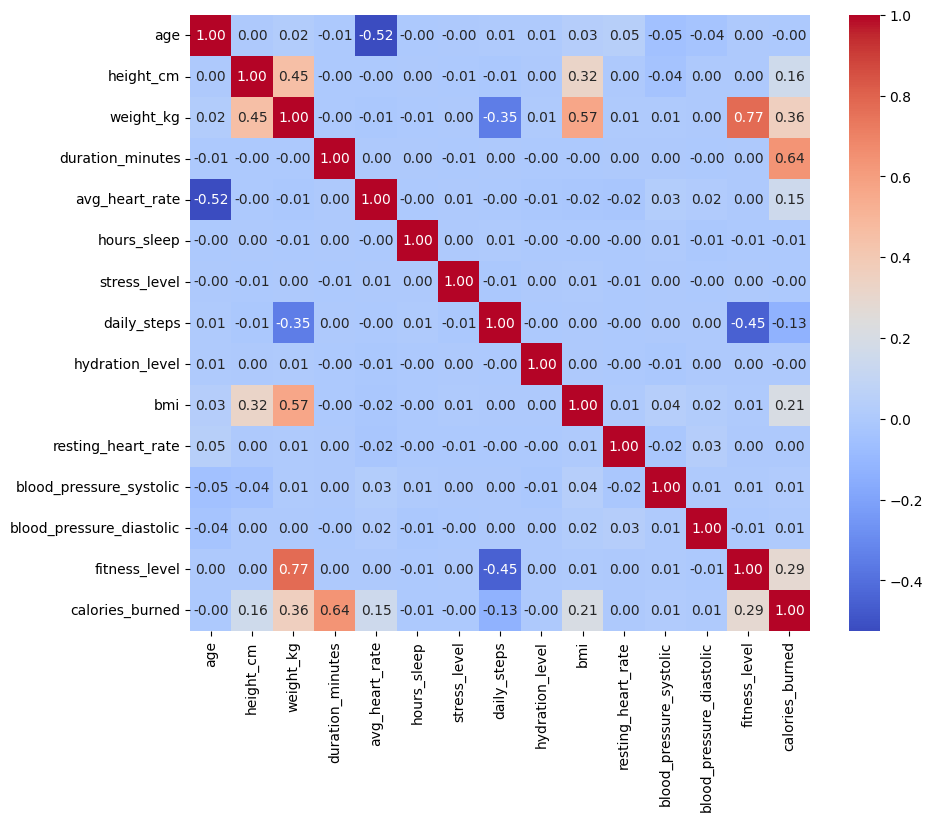

In [20]:
train_data = X_train.copy()
train_data["calories_burned"] = y_train
corr = train_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [21]:
from scipy.stats import f_oneway
cat_columns = [i for i in train_data.columns if train_data[i].dtype=="O"]

for feature in cat_columns:
    groups = [train_data[train_data[feature] == cat]["calories_burned"] for cat in train_data[feature].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(feature,"ANOVA F-statistic:", f_stat, "P-value:", p_value)

gender ANOVA F-statistic: 514.9726756958627 P-value: 2.3876021710266418e-222
activity_type ANOVA F-statistic: 2793.5868432672137 P-value: 0.0
intensity ANOVA F-statistic: 1167.8311862814664 P-value: 0.0
health_condition ANOVA F-statistic: 4.547929002813031 P-value: 0.003434857933411388
smoking_status ANOVA F-statistic: 2.2063887459847615 P-value: 0.11010707315145538


In [22]:
train_data.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'activity_type',
       'duration_minutes', 'intensity', 'avg_heart_rate', 'hours_sleep',
       'stress_level', 'daily_steps', 'hydration_level', 'bmi',
       'resting_heart_rate', 'blood_pressure_systolic',
       'blood_pressure_diastolic', 'health_condition', 'smoking_status',
       'fitness_level', 'calories_burned'],
      dtype='object')

#### REMOVING LESS IMPORTANT FEATURES

In [23]:
drop_columns = ["hours_sleep", "stress_level","daily_steps", "hydration_level","avg_heart_rate","blood_pressure_systolic","resting_heart_rate","blood_pressure_diastolic","health_condition","smoking_status"]
X_train.drop(columns=drop_columns, inplace=True)

#### CHECKING FOR OUTLIERS

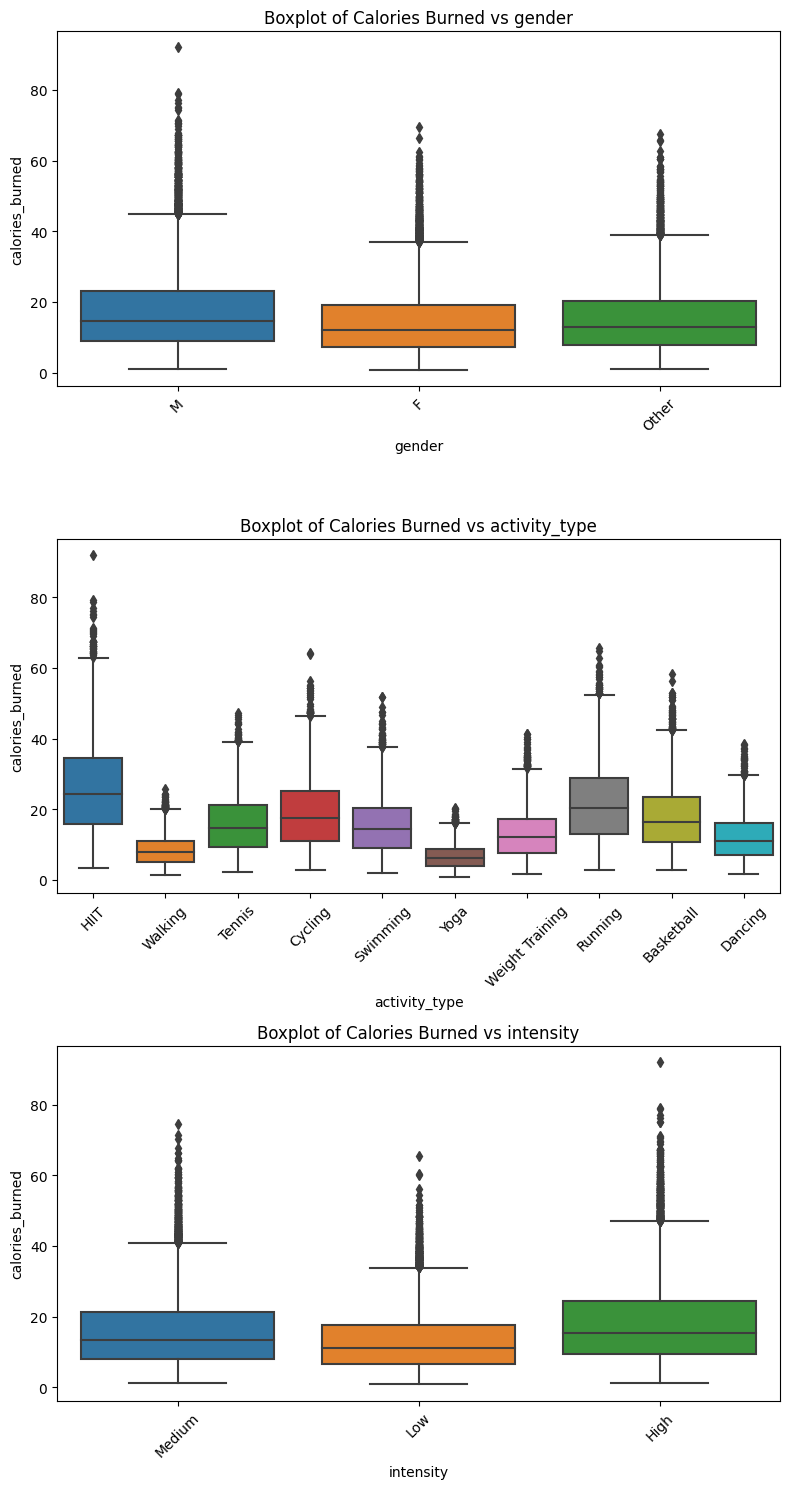

In [24]:
cat_columns = [i for i in X_train.columns if X_train[i].dtype=="O"]
fig,axes = plt.subplots(nrows=len(cat_columns), figsize=(8, 5 * len(cat_columns)))

for ax, col in zip(axes, cat_columns):
    sns.boxplot(x=X_train[col], y=y_train, ax=ax)
    ax.set_title(f"Boxplot of Calories Burned vs {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x labels if needed
    
plt.tight_layout()
plt.show()

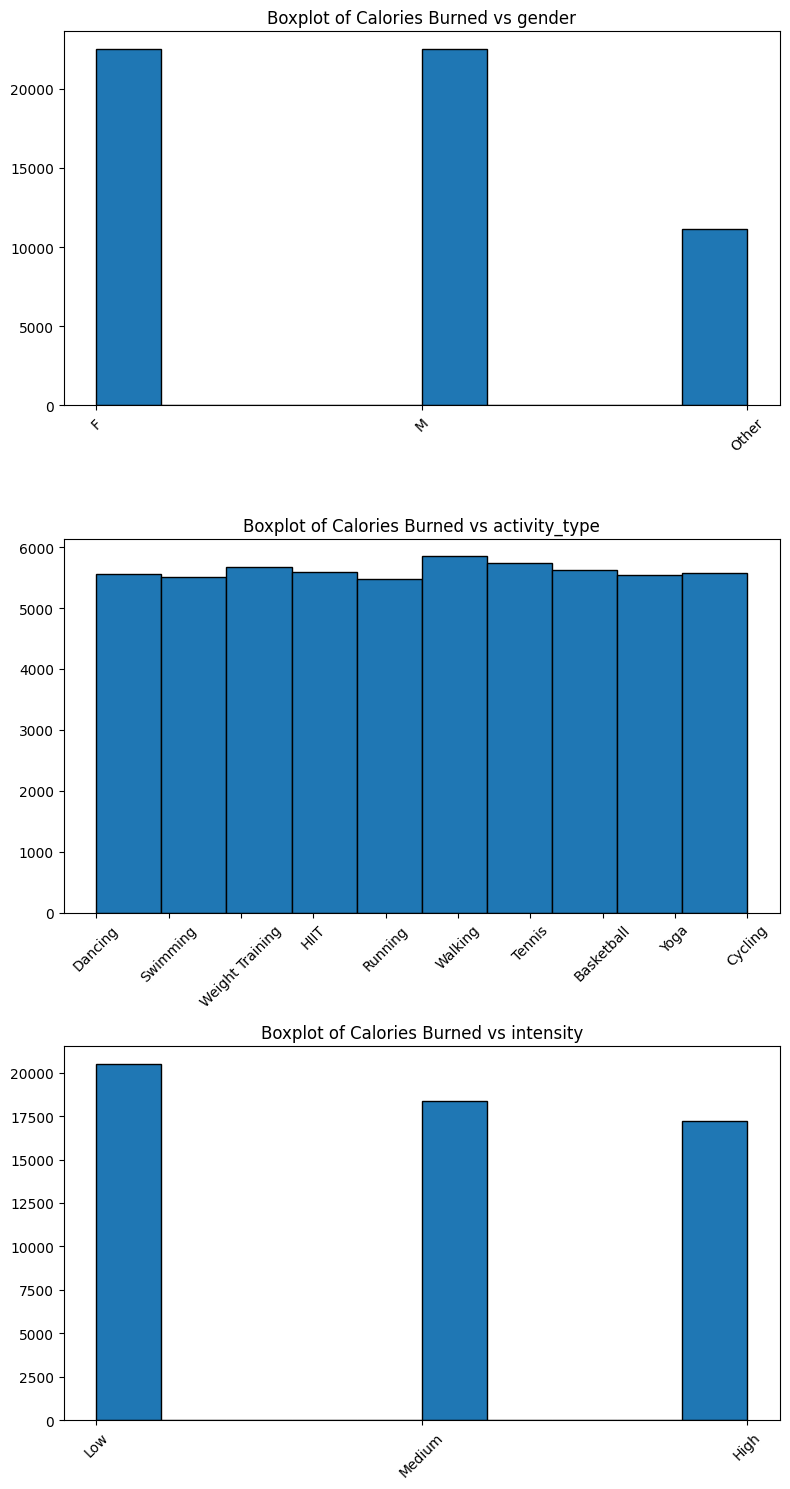

In [25]:
fig,axes = plt.subplots(nrows=len(cat_columns), figsize=(8, 5 * len(cat_columns)))

for ax, col in zip(axes, cat_columns):
    ax.hist(x=X_train[col], bins=10, edgecolor="black")
    ax.set_title(f"Boxplot of Calories Burned vs {col}")
    ax.set_xticks(range(len(df[col].unique())))  
    ax.set_xticklabels(df[col].unique(), rotation=45)
    
plt.tight_layout()
plt.show()

## DATA PREPROCESSING

#### REMOVING OUTLIERS

In [26]:
def cap_outliers(group):
    Q1 = group["calories_burned"].quantile(0.25)
    Q3 = group["calories_burned"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    group["calories_burned"] = group["calories_burned"].clip(lower=lower_bound, upper=upper_bound)
    return group

for feature in cat_columns:
    train_data = train_data.groupby(feature).apply(cap_outliers)

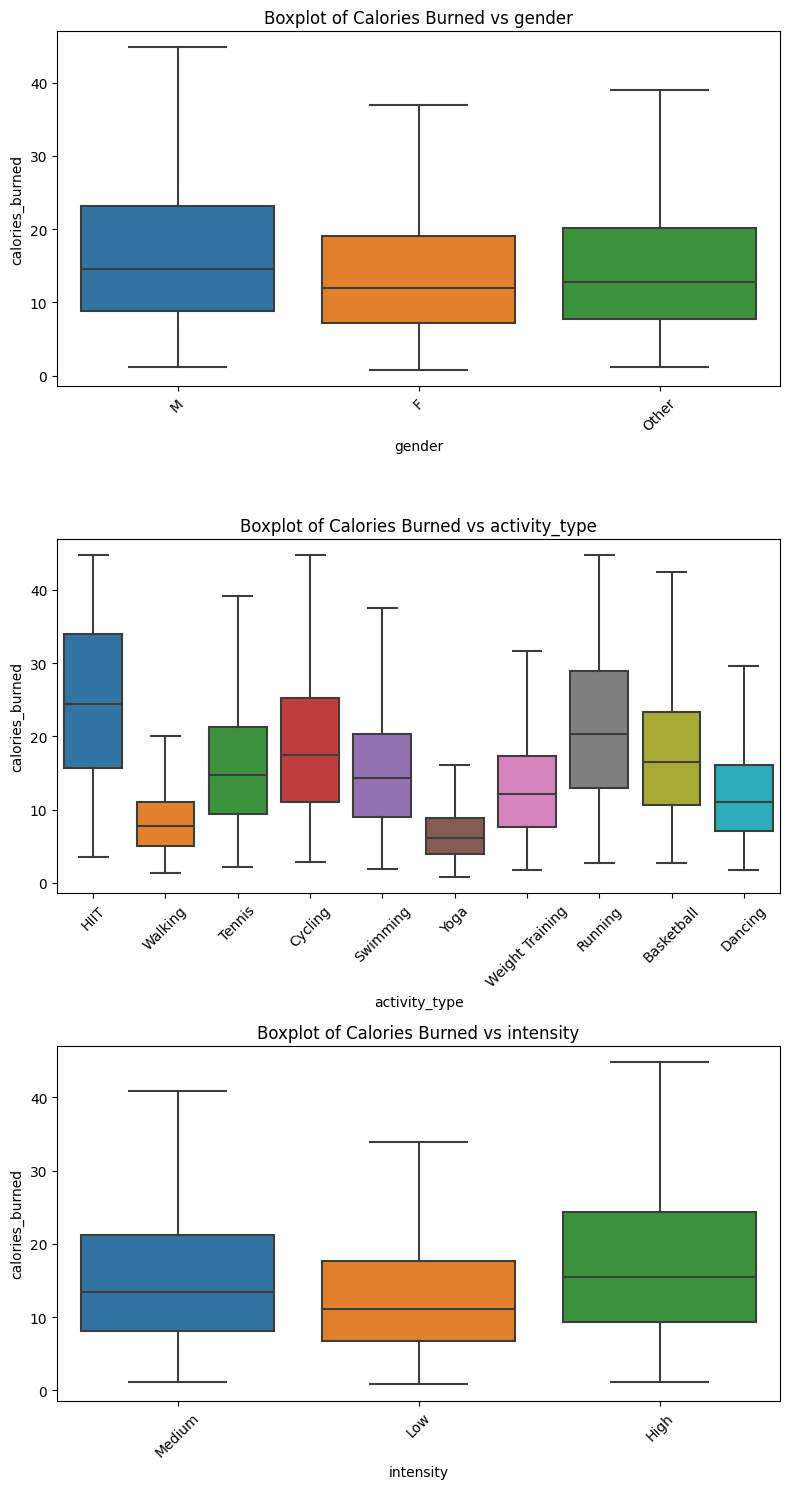

In [27]:
fig,axes = plt.subplots(nrows=len(cat_columns), figsize=(8, 5 * len(cat_columns)))

for ax, col in zip(axes, cat_columns):
    sns.boxplot(x=train_data[col], y=train_data["calories_burned"], ax=ax)
    ax.set_title(f"Boxplot of Calories Burned vs {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x labels if needed
    
plt.tight_layout()
plt.show()

In [29]:
train_data.head()

,age,gender,height_cm,weight_kg,activity_type,duration_minutes,intensity,avg_heart_rate,hours_sleep,stress_level,daily_steps,hydration_level,bmi,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,health_condition,smoking_status,fitness_level,calories_burned
41460,50,M,171.9,69.9,HIIT,29,Medium,114,5.9,7,9266,1.9,22.4,62.6,137.0,61.0,None,Never,1.07,8.1
52536,44,M,164.8,91.2,Walking,25,Low,114,9.0,7,7094,2.7,27.9,65.2,126.7,93.9,Hypertension,Former,4.83,2.4
50941,21,M,187.9,59.6,Tennis,96,Medium,150,6.6,4,9984,3.5,14.2,70.1,110.1,84.7,None,Never,3.03,13.9
22278,60,F,163.2,82.2,Walking,93,Low,100,8.9,6,9363,2.9,27.8,72.3,136.1,83.0,Diabetes,Current,2.74,8.0
34427,55,M,173.3,107.6,Cycling,53,Low,97,7.8,7,10387,3.2,28.1,72.9,113.0,82.2,None,Former,7.27,13.4


In [30]:
df.columns

Index(['participant_id', 'date', 'age', 'gender', 'height_cm', 'weight_kg',
       'activity_type', 'duration_minutes', 'intensity', 'calories_burned',
       'avg_heart_rate', 'hours_sleep', 'stress_level', 'daily_steps',
       'hydration_level', 'bmi', 'resting_heart_rate',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'health_condition', 'smoking_status', 'fitness_level'],
      dtype='object')

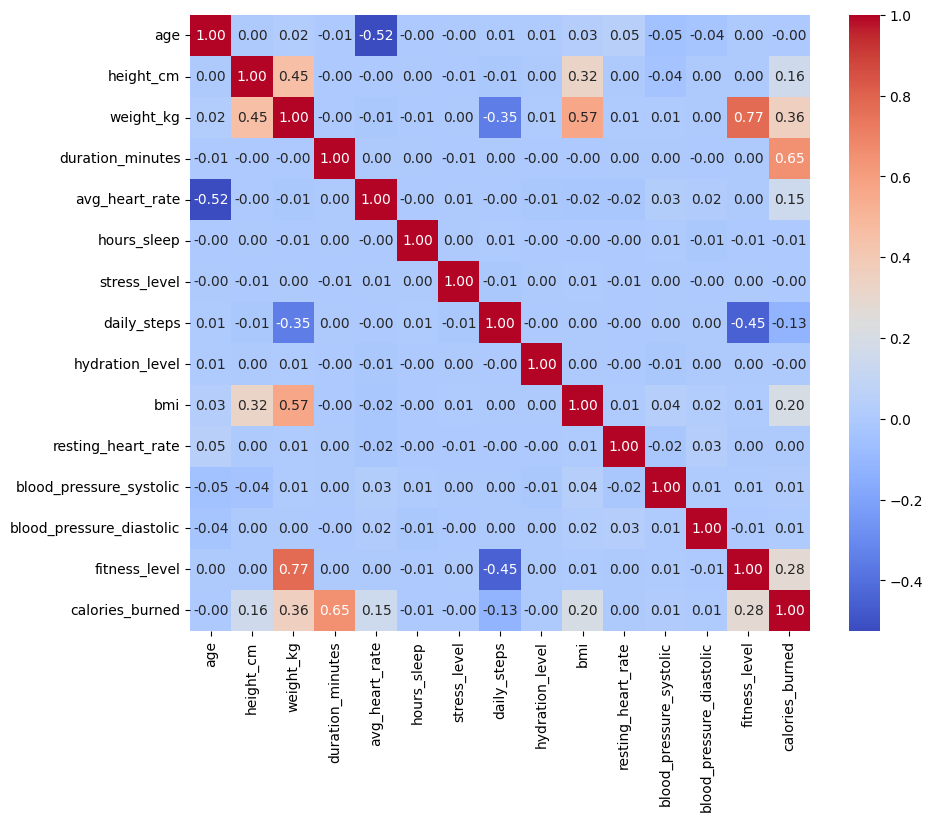

In [31]:
corr = train_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [32]:
print("intensity","--->",train_data["intensity"].unique())

intensity ---> ['Medium' 'Low' 'High']


## MODEL SELECTION & TRAINING

#### CREATING PREPROCESSING PIPELINE

In [33]:
categorical_features = ['activity_type', 'gender']
numerical_features = ['age', 'weight_kg', 'height_cm', 'bmi','duration_minutes']
intensity_features = ['intensity']


categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

intensity_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])


preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features),
    ('intensity', intensity_transformer, intensity_features)
])


In [34]:
X_train.head()

,age,gender,height_cm,weight_kg,activity_type,duration_minutes,intensity,bmi,fitness_level
41460,50,M,171.9,69.9,HIIT,29,Medium,22.4,1.07
52536,44,M,164.8,91.2,Walking,25,Low,27.9,4.83
50941,21,M,187.9,59.6,Tennis,96,Medium,14.2,3.03
22278,60,F,163.2,82.2,Walking,93,Low,27.8,2.74
34427,55,M,173.3,107.6,Cycling,53,Low,28.1,7.27


#### CREATING MODEL PIPELINE

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Machine': SVR()
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'R2 Score': r2}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)


RANDOM FOREST PERFORMS BEST IN ALL MODEL

#### HYPERPARAMETER TUNING

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Tree depth (None means unlimited)
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5]  # Minimum samples in a leaf node
}

results = []

def evaluate_model(y_true, y_pred, dataset_name, parameters):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {f"mae{dataset_name}": mae, f"mse{dataset_name}":mse, f"r2{dataset_name}":r2}

for n_estimators, max_depth, min_samples_split, min_samples_leaf in product(
        param_grid['n_estimators'], param_grid['max_depth'], param_grid['min_samples_split'], param_grid['min_samples_leaf']):
    model = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, random_state=42)
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    result_train = evaluate_model(y_train, y_train_pred, "_train",[n_estimators, max_depth, min_samples_split, min_samples_leaf])
    result_test = evaluate_model(y_test, y_test_pred, "_test",[n_estimators, max_depth, min_samples_split, min_samples_leaf])
    overfitting = {"overfitting": (result_train["r2_train"] - result_test["r2_test"]) > 0.02}
    parameters = {"param": {"n_estimators": n_estimators, "max_depth": max_depth, "min_samples_split": min_samples_split, "min_samples_leaf": min_samples_leaf}}
    data = {**result_train, **result_test, **overfitting, **parameters}
    results.append(data)
    print(data)
    
df_results = pd.DataFrame(results)

{'mae_train': 0.09494996079549509, 'mse_train': 0.025784931926723195, 'r2_train': 0.999749188385116, 'mae_test': 0.2338601518229445, 'mse_test': 0.15040325884742856, 'r2_test': 0.9985446453748457, 'overfitting': False, 'param': {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}}
{'mae_train': 0.11359553707137461, 'mse_train': 0.040810092781741185, 'r2_train': 0.9996030377236115, 'mae_test': 0.23579002420711498, 'mse_test': 0.15560036730710508, 'r2_test': 0.9984943563326256, 'overfitting': False, 'param': {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}}
{'mae_train': 0.19908726833806628, 'mse_train': 0.1260173141465756, 'r2_train': 0.9987742218535124, 'mae_test': 0.2894642532243799, 'mse_test': 0.23326520208681997, 'r2_test': 0.99774284418206, 'overfitting': False, 'param': {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5}}
{'mae_train': 0.11584123103825902, 'mse_train': 0.039

{'mae_train': 0.08823839903057945, 'mse_train': 0.023036489771188256, 'r2_train': 0.9997759226505933, 'mae_test': 0.22575585373676882, 'mse_test': 0.14273114567518438, 'r2_test': 0.9986188834297621, 'overfitting': False, 'param': {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}}
{'mae_train': 0.10689064136015854, 'mse_train': 0.03767378913946314, 'r2_train': 0.9996335447415676, 'mae_test': 0.2280317871540354, 'mse_test': 0.14857714382674087, 'r2_test': 0.9985623155035502, 'overfitting': False, 'param': {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}}
{'mae_train': 0.19233423559386814, 'mse_train': 0.12094671328632862, 'r2_train': 0.9988235438991864, 'mae_test': 0.28203848319598046, 'mse_test': 0.22567882482759866, 'r2_test': 0.9978162526262452, 'overfitting': False, 'param': {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5}}
{'mae_train': 0.10919463165349948, 'mse_train'

{'mae_train': 0.08503090918811035, 'mse_train': 0.021621206817128848, 'r2_train': 0.9997896891947221, 'mae_test': 0.22187985138458247, 'mse_test': 0.13779061484283117, 'r2_test': 0.9986666897369705, 'overfitting': False, 'param': {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}}
{'mae_train': 0.10384734279056926, 'mse_train': 0.036345495580533536, 'r2_train': 0.9996464651345127, 'mae_test': 0.2247623320698305, 'mse_test': 0.14418804230549512, 'r2_test': 0.9986047859875555, 'overfitting': False, 'param': {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}}
{'mae_train': 0.18999264988532855, 'mse_train': 0.11877757604726147, 'r2_train': 0.9988446432301981, 'mae_test': 0.2801133170938344, 'mse_test': 0.22203169897368089, 'r2_test': 0.9978515434937483, 'overfitting': False, 'param': {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5}}
{'mae_train': 0.10630650448026302, 'mse_train'

#### SAVE RESULTS FOR FUTURE REFERENCE

In [31]:
df_results.to_csv("results.csv")

In [12]:
df_results = pd.read_csv("results.csv")

In [32]:
df_results = df_results.sort_values(by=["r2_test"], ascending=False)

In [35]:
pd.set_option('display.max_colwidth', None)
df_results.head(30)

,mae_train,mse_train,r2_train,mae_test,mse_test,r2_test,overfitting,param
54,0.085031,0.021621,0.999790,0.221880,0.137791,0.998667,False,"{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}"
72,0.093242,0.024579,0.999761,0.225508,0.140817,0.998637,False,"{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}"
27,0.088238,0.023036,0.999776,0.225756,0.142731,0.998619,False,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}"
55,0.103847,0.036345,0.999646,0.224762,0.144188,0.998605,False,"{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}"
57,0.106307,0.034999,0.999660,0.227833,0.144540,0.998601,False,"{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}"
45,0.096174,0.025952,0.999748,0.228834,0.145184,0.998595,False,"{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}"
73,0.108325,0.038014,0.999630,0.227459,0.146582,0.998582,False,"{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}"
58,0.111322,0.041614,0.999595,0.227322,0.147246,0.998575,False,"{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2}"
75,0.111414,0.037086,0.999639,0.230776,0.147693,0.998571,False,"{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}"
30,0.109195,0.036308,0.999647,0.230744,0.147819,0.998570,False,"{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}"


🚀 Final Verdict: Is This The Best?
✅ Yes! This configuration (n_estimators=100, max_depth=20) has the best balance of accuracy and efficiency.
🚀 Use this model moving forward. If you need further improvement, you could try:

Reducing max_depth slightly (e.g., max_depth=15)

#### TRAINING MODEL WITH BEST PARAMETERS

In [37]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_model', rf)
])

pipeline_rf.fit(X_train, y_train)

cv_r2_scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='r2')

print("CV R2 Scores: ",cv_r2_scores)
print("Mean R2 Scores: ",np.mean(cv_r2_scores))
print("Standard Deviation R2 Scores: ",np.std(cv_r2_scores))

CV R2 Scores:  [0.99795417 0.99798541 0.99807851 0.99807549 0.99802801]
Mean R2 Scores:  0.9980243166768246
Standard Deviation R2 Scores:  4.899930254334006e-05


#### CHECKING FOR MOST IMPORTANT FEATURES

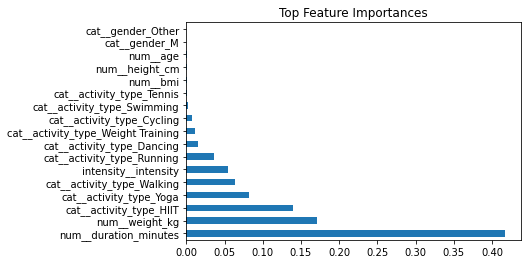

In [46]:
importances = pd.Series(pipeline_rf['rf_model'].feature_importances_, index=pipeline_rf['preprocessor'].get_feature_names_out())
importances.nlargest(25).plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()

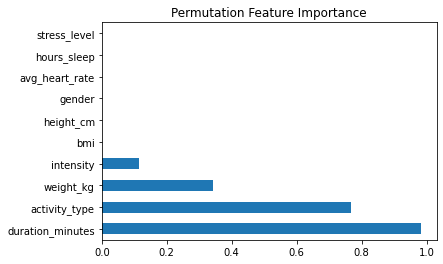

In [47]:
from sklearn.inspection import permutation_importance

# Get permutation importance
perm_importance = permutation_importance(pipeline_rf, X_test, y_test, scoring='r2')

# Convert to pandas Series
perm_importances = pd.Series(perm_importance.importances_mean, index=X_test.columns)

# Plot
perm_importances.nlargest(10).plot(kind='barh')
plt.title("Permutation Feature Importance")
plt.show()


#### TRAINING FINAL MODEL WITH MOST IMPORTANT FEATURES

In [28]:
categorical_features2 = ['activity_type']
numerical_features2 = ['age', 'height_cm','weight_kg','duration_minutes']
intensity_features2= ['intensity']


categorical_transformer2 = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

numerical_transformer2 = Pipeline([
    ('scaler', StandardScaler())
])

intensity_transformer2 = Pipeline([
    ('encoder', OrdinalEncoder())
])


preprocessor2 = ColumnTransformer([
    ('cat', categorical_transformer2, categorical_features2),
    ('num', numerical_transformer2, numerical_features2),
    ('intensity', intensity_transformer2, intensity_features2)
])


In [29]:
X_train = train_data.drop(columns=["calories_burned"])
y_train = train_data["calories_burned"]

In [30]:
rf2 = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)

pipeline_rf2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('rf_model', rf2)
])

pipeline_rf2.fit(X_train, y_train)

cv_r2_scores2 = cross_val_score(pipeline_rf2, X_train, y_train, cv=5, scoring='r2')
print("CV R2 Scores: ",cv_r2_scores2)
print("Mean R2 Scores: ",np.mean(cv_r2_scores2))
print("Standard Deviation R2 Scores: ",np.std(cv_r2_scores2))

CV R2 Scores:  [0.99736151 0.99733125 0.99739163 0.9971747  0.9973626 ]
Mean R2 Scores:  0.9973243385940849
Standard Deviation R2 Scores:  7.721993161317292e-05


In [ ]:
# Get permutation importance
perm_importance2 = permutation_importance(pipeline_rf2, X_test, y_test, scoring='r2')

# Convert to pandas Series
perm_importances2 = pd.Series(perm_importance2.importances_mean, index=X_test.columns)

# Plot
perm_importances2.nlargest(10).plot(kind='barh')
plt.title("Permutation Feature Importance")
plt.show()

2️⃣ Why Does Gender Still Have No Importance?
🚀 Possible Reasons: 1️⃣ Other Features Explain Calories Burned Better

If your dataset has age, BMI, or duration, these might be stronger predictors.
Gender alone might not add much predictive value after BMI is included.

#### SAVING FINAL MODEL

In [40]:
joblib.dump(pipeline_rf2, "../model/rf_model.pkl")

['../model/rf_model.pkl']

In [43]:
pipeline_rf2["preprocessor"].get_feature_names_out()

array(['cat__activity_type_Cycling', 'cat__activity_type_Dancing',
       'cat__activity_type_HIIT', 'cat__activity_type_Running',
       'cat__activity_type_Swimming', 'cat__activity_type_Tennis',
       'cat__activity_type_Walking', 'cat__activity_type_Weight Training',
       'cat__activity_type_Yoga', 'num__age', 'num__height_cm',
       'num__weight_kg', 'num__duration_minutes', 'intensity__intensity'],
      dtype=object)

In [60]:
raw_input = pd.DataFrame([{
    'activity_type': 'Running',
    'age': 30,
    'height_cm': 175.0,
    'weight_kg': 70.0,
    'duration_minutes': 30,
    'intensity': 'High'
}])

prediction = pipeline_rf2.predict(raw_input)

print("Predicted Calories Burned:", prediction[0] * raw_input["duration_minutes"])

Predicted Calories Burned: 0    236.34
Name: duration_minutes, dtype: float64
